In [47]:
    ##Borrar datos del entorno
rm(list=ls())


#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,janitor,httr,jsonlite,gt,sf,rmapshaper,showtext)
font_add_google("Poppins", "pop")
showtext_auto()


In [48]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

# Obtener datos de autoproducción por ONAVI


### SHF

In [49]:
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2024,2024/0/0/organismo,modalidad,destino_credito,anio,mes,rango_edad,genero,estado"


In [50]:
finan_gral<-consulta_api(url)%>%
arrange(año)
str(finan_gral)

'data.frame':	5244 obs. of  10 variables:
 $ año            : int  2024 2024 2024 2024 2024 2024 2024 2024 2024 2024 ...
 $ mes            : chr  "enero" "enero" "enero" "enero" ...
 $ estado         : chr  "Aguascalientes" "Baja California" "Chiapas" "Chihuahua" ...
 $ organismo      : chr  "FOVISSSTE" "FOVISSSTE" "FOVISSSTE" "FOVISSSTE" ...
 $ modalidad      : chr  "Viviendas nuevas" "Viviendas nuevas" "Viviendas nuevas" "Viviendas nuevas" ...
 $ destino_credito: chr  "Vivienda nueva" "Vivienda nueva" "Vivienda nueva" "Vivienda nueva" ...
 $ sexo           : chr  "Hombre" "Hombre" "Hombre" "Hombre" ...
 $ grupo_edad     : chr  "29 o menos" "29 o menos" "29 o menos" "29 o menos" ...
 $ acciones       : int  4 1 1 1 1 1 1 1 4 1 ...
 $ monto          : num  2760000 1380343 775000 1210000 1394519 ...


In [51]:
shf <- finan_gral %>%
  filter(organismo == "SHF (FONDEO)" &
         destino_credito %in% c("Autoproducción", "Ampliación", "Reconstrucción", "Mejoramientos"))%>%
group_by(año,organismo, grupo_edad,sexo,modalidad,estado)%>%
summarise(creditos=sum(acciones),monto=sum(monto))
head(shf,5)

`summarise()` has grouped output by 'año', 'organismo', 'grupo_edad', 'sexo',
'modalidad'. You can override using the `.groups` argument.


año,organismo,grupo_edad,sexo,modalidad,estado,creditos,monto
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
2024,SHF (FONDEO),29 o menos,Hombre,Mejoramientos,Aguascalientes,56,0
2024,SHF (FONDEO),29 o menos,Hombre,Mejoramientos,Baja California,53,0
2024,SHF (FONDEO),29 o menos,Hombre,Mejoramientos,Campeche,70,0
2024,SHF (FONDEO),29 o menos,Hombre,Mejoramientos,Chiapas,502,0
2024,SHF (FONDEO),29 o menos,Hombre,Mejoramientos,Chihuahua,3,0


### Fovissste

In [52]:
fovissste<-finan_gral%>%
filter(organismo=="FOVISSSTE" &
       destino_credito %in% c("Con disponibilidad de terreno"))%>%
group_by(año,organismo, grupo_edad,sexo,modalidad,estado)%>%
summarise(creditos=sum(acciones),monto=sum(monto))
head(fovissste,5)

`summarise()` has grouped output by 'año', 'organismo', 'grupo_edad', 'sexo',
'modalidad'. You can override using the `.groups` argument.


año,organismo,grupo_edad,sexo,modalidad,estado,creditos,monto
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
2024,FOVISSSTE,29 o menos,Hombre,Viviendas nuevas,Baja California Sur,1,664009.7
2024,FOVISSSTE,29 o menos,Hombre,Viviendas nuevas,Chiapas,1,708331.9
2024,FOVISSSTE,29 o menos,Mujer,Viviendas nuevas,Sonora,1,1377500.0
2024,FOVISSSTE,30 a 59,Hombre,Viviendas nuevas,Chiapas,5,4158054.4
2024,FOVISSSTE,30 a 59,Hombre,Viviendas nuevas,Chihuahua,1,770578.2


### Infonavit   

In [53]:
url_infonavit<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetINFONAVIT/2024,2024/0/0/anio,linea_credito,modalidad,genero,rango_edad,estado"

In [54]:
bdinfonavit<-consulta_api(url_infonavit)%>%
arrange(año)

In [55]:
infonavit<-bdinfonavit%>%
filter(linea_credito %in% c("Linea II", "Linea III","Linea IV"))%>%
filter(modalidad %in% c("Adquisicion de suelo", "Ampliación y rehabilitación","Autoconstrucción","Con disponibilidad de terreno"))%>%
group_by(año,grupo_edad,sexo,modalidad,estado)%>%
summarise(creditos=sum(acciones),monto=sum(monto))%>%
mutate(organismo="INFONAVIT")
head(infonavit,5)

`summarise()` has grouped output by 'año', 'grupo_edad', 'sexo', 'modalidad'.
You can override using the `.groups` argument.


año,grupo_edad,sexo,modalidad,estado,creditos,monto,organismo
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
2024,29 o menos,Hombre,Ampliación y rehabilitación,Aguascalientes,121,74550.19,INFONAVIT
2024,29 o menos,Hombre,Ampliación y rehabilitación,Baja California,235,185687.00,INFONAVIT
2024,29 o menos,Hombre,Ampliación y rehabilitación,Baja California Sur,36,0.00,INFONAVIT
2024,29 o menos,Hombre,Ampliación y rehabilitación,Campeche,36,172672.88,INFONAVIT
2024,29 o menos,Hombre,Ampliación y rehabilitación,Chiapas,131,837185.00,INFONAVIT


### Conavi

In [56]:
url_conavi<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetCONAVI/2024,2024/0/0/modalidad,anio,mes,genero,rango_edad,estado"

In [57]:
bdconavi<-consulta_api(url_conavi)%>%
filter(mes!="abril")%>%
arrange(año)

In [58]:
conavi<-bdconavi%>%
filter(modalidad %in% c("Autoproducción", "Autoconstrucción", "Ampliación", "Mejoramiento","Reconstrucción","Vivienda existente"))%>%
group_by(año,grupo_edad,sexo,modalidad,estado)%>%

summarise(creditos=sum(acciones),monto=sum(monto))%>%
mutate(organismo="CONAVI")


conavi

`summarise()` has grouped output by 'año', 'grupo_edad', 'sexo', 'modalidad'.
You can override using the `.groups` argument.


año,grupo_edad,sexo,modalidad,estado,creditos,monto,organismo
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
2024,29 o menos,Hombre,Mejoramiento,Aguascalientes,34,1190000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Baja California,68,2380000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Baja California Sur,87,3045000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Campeche,34,1190000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Chiapas,191,6685000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Chihuahua,79,2765000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Coahuila de Zaragoza,32,1120000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Colima,40,1400000,CONAVI
2024,29 o menos,Hombre,Mejoramiento,Durango,200,7000000,CONAVI


In [59]:
autoproduccion<-bind_rows(shf,fovissste,infonavit,conavi)
print(sprintf("Total de financiamientos para autoproducción: %s", format(sum(autoproduccion$creditos), big.mark = ",")))
#Guardar datos en excel
openxlsx::write.xlsx(autoproduccion,"autoproduccion_1T_2024.xlsx")

[1] "Total de financiamientos para autoproducción: 134,181"


### Mapa

In [68]:
paleta_mapa<- rev(c("#7e5f33","#a27b42","#bc955c","#caac80","#d9c4a4"))

In [61]:
estados<-st_read("https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson")%>%
  #Renombrar Distrito Federal como Ciudad de México
mutate(state_name=case_when(state_name=="Distrito Federal" ~ "Ciudad de México",
TRUE ~ state_name))

#Mapa de México sin estados
mapamx<-estados%>%
#Corregir geometría
mutate(geometry = ms_simplify(geometry, keep_shapes = TRUE))%>%
st_union()

Reading layer `states' from data source 
  `https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.4 ymin: 14.5321 xmax: -86.72404 ymax: 32.71865
Geodetic CRS:  WGS 84


In [62]:
data_mapa<-autoproduccion%>%
group_by(estado)%>%
summarise(creditos=sum(creditos))
data_mapa

estado,creditos
<chr>,<int>
Aguascalientes,2742
Baja California,4679
Baja California Sur,2746
Campeche,1851
Chiapas,6674
Chihuahua,4987
Ciudad de México,4380
Coahuila de Zaragoza,3523
Colima,2724


In [63]:
ent<-estados%>%
  left_join(data_mapa,by=c("state_name"="estado"))%>%
mutate(creditos=creditos/1000)

ent

ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called 'geojsonio'

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

,id,state_code,state_name,creditos,geometry
,<chr>,<int>,<chr>,<dbl>,<MULTIPOLYGON [°]>
1,NA,9,Ciudad de México,4.380,MULTIPOLYGON (((-99.09052 1...
2,NA,12,Guerrero,2.799,MULTIPOLYGON (((-100.5388 1...
3,NA,15,México,12.861,MULTIPOLYGON (((-99.85919 2...
4,NA,17,Morelos,2.145,MULTIPOLYGON (((-99.06199 1...
5,NA,25,Sinaloa,3.763,MULTIPOLYGON (((-108.4705 2...
6,NA,2,Baja California,4.679,MULTIPOLYGON (((-115.2138 2...
7,NA,26,Sonora,3.608,MULTIPOLYGON (((-112.5544 2...
8,NA,3,Baja California Sur,2.746,MULTIPOLYGON (((-109.8005 2...
9,NA,32,Zacatecas,2.024,MULTIPOLYGON (((-101.6003 2...


In [64]:
ent$acciones_cat <- cut(ent$creditos, breaks = 4)

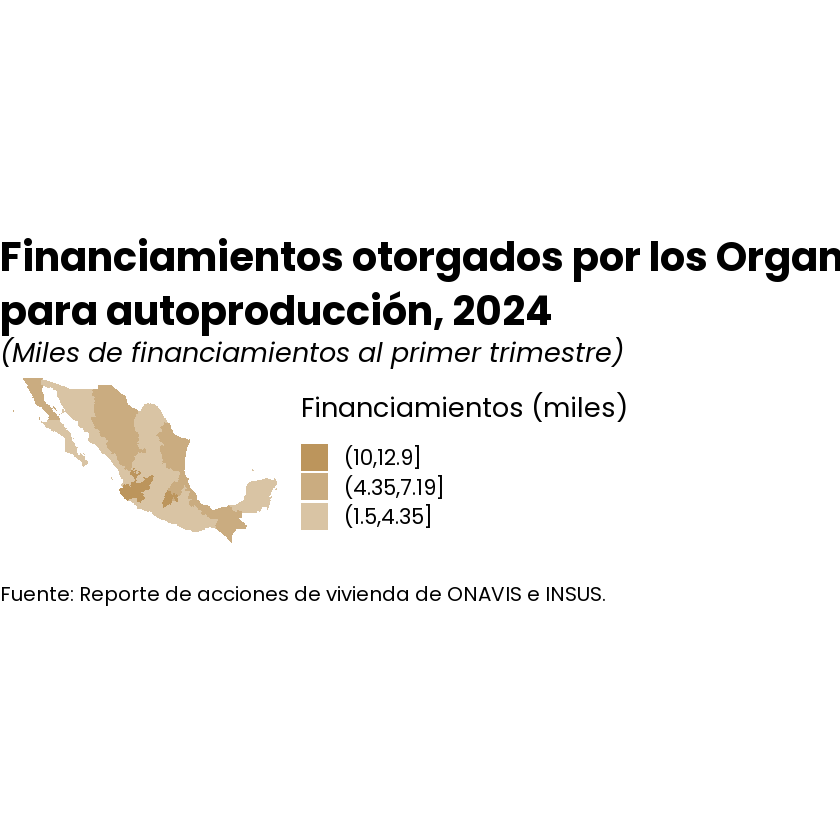

In [71]:
ent%>%
  ggplot() +
  # Capa con datos de los municipios
  geom_sf(data=ent,aes(fill = acciones_cat),
          colour = "#1C00ff00", size = 0.07) +
  # Agrega título, subtítulo y fuente
  labs(title = "Financiamientos otorgados por los Organismos Nacionales de Vivienda
para autoproducción, 2024",
       subtitle="(Miles de financiamientos al primer trimestre)",
       caption = "
Fuente: Reporte de acciones de vivienda de ONAVIS e INSUS.") +
  scale_fill_manual("Financiamientos (miles)",values = paleta_mapa)+
  guides(fill = guide_legend(reverse = TRUE)) +
    theme_void()+
  theme(plot.title = element_text(hjust = 0, size=30,face="bold"),
        plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
        plot.caption = element_text(hjust = 0,size=15),
        legend.position="right",
        #Fuente y tamaño
        text=element_text("pop",
                          size=20))

ggsave("mapa_autoprod.png",height = 10,width = 20, units="in",dpi=100, bg='white')
ggsave("mapa_autoprod.svg",height = 10,width = 20, units="in",dpi=100, bg='white')

